# Step 1: Postprocessing of raw eddy-covariance data

In [1]:
#loading Reddy package
install.packages("../src/Reddy_0.0.0.9000.tar.gz",repos=NULL,source=TRUE)
library(Reddy)

Installing package into ‘/home/lauracma/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)



In [2]:
#ec data files
dir_in="../data/ec-data_10Hz"
files=list.files(dir_in,full.names=TRUE)
nf=length(files)

In [3]:
#allocate output
var_out=c("time","u_mean","v_mean","w_mean","ws_mean","wd_mean","T_mean","q_mean","co2_mean",
          "u_sd","v_sd","w_sd","T_sd","q_sd","co2_sd",
          "cov_uv","cov_uw","cov_vw","cov_wT","cov_qw","cov_co2w",
          "rot_angle1","rot_angle2","flag_stationarity","flag_w","flag_distortion")
nv=length(var_out)
dat=data.frame(array(NA,dim=c(nf,nv)))
colnames(dat)=var_out

In [4]:
#postprocessing per file (30 mins)
for (i in 1:nf) {
    tmp=read.table(files[i],sep=",",header=T)
    dat$time=tmp$X[1]
    #despiking
    tmp$T_degC=despiking(tmp$T_degC,-40,30)
    tmp$u_m.s=despiking(tmp$u_m.s,-25,25)
    tmp$v_m.s=despiking(tmp$v_m.s,-25,25)
    tmp$w_m.s=despiking(tmp$w_m.s,-5,5)
    #wind before rotation
    dat$ws_mean=sqrt(mean(tmp$u_m.s,na.rm=T)^2+mean(tmp$v_m.s,na.rm=T)^2)
    dat$wd_mean=atan2(mean(tmp$v_m.s,na.rm=T)^2,mean(tmp$u_m.s,na.rm=T)^2)
    #rotation
    rot_wind=rotate_double(tmp$u_m.s,tmp$v_m.s,tmp$w_m.s)
    #tmp$u_m.s=rot_wind$u
    #tmp$v_m.s=rot_wind$v
    #tmp$w_m.s=rot_wind$w
    dat$rot_angle1[i]=rot_wind$theta
    dat$rot_angle2[i]=rot_wind$phi
    #averaging
    dat$u_mean[i]=mean(tmp$u_m.s,na.rm=T)
    dat$v_mean[i]=mean(tmp$v_m.s,na.rm=T)
    dat$w_mean[i]=mean(tmp$w_m.s,na.rm=T)
    dat$T_mean[i]=mean(tmp$T_degC,na.rm=T)
    dat$q_mean[i]=mean(tmp$H2O_ppt,na.rm=T)
    dat$co2_mean[i]=mean(tmp$CO2_ppm,na.rm=T)
    dat$u_sd[i]=sd(tmp$u_m.s,na.rm=T)
    dat$v_sd[i]=sd(tmp$v_m.s,na.rm=T)
    dat$w_sd[i]=sd(tmp$w_m.s,na.rm=T)
    dat$T_sd[i]=sd(tmp$T_degC,na.rm=T)
    dat$q_sd[i]=sd(tmp$H2O_ppt,na.rm=T)
    dat$co2_sd[i]=sd(tmp$CO2_ppm,na.rm=T)
    dat$cov_uw[i]=cov(tmp$u_m.s,tmp$w_m.s,use="pairwise.complete.obs")
    dat$cov_uv[i]=cov(tmp$u_m.s,tmp$v_m.s,use="pairwise.complete.obs")
    dat$cov_vw[i]=cov(tmp$v_m.s,tmp$w_m.s,use="pairwise.complete.obs")
    dat$cov_wT[i]=cov(tmp$T_degC,tmp$w_m.s,use="pairwise.complete.obs")
    dat$cov_qw[i]=cov(tmp$H2O_ppt,tmp$w_m.s,use="pairwise.complete.obs")
    dat$cov_co2w[i]=cov(tmp$CO2_ppm,tmp$w_m.s,use="pairwise.complete.obs")
    #SND correction
    #cov_wT_snd=SNDcorrection(tmp$u_m.s,tmp$v_m.s,tmp$w_m.s,tmp$T_degC)
    #flagging
    dat$flag_stationarity[i]=flag_stationarity(tmp$w_m.s,tmp$T_degC)
    dat$flag_w[i]=flag_w(dat$w_mean[i])
    dat$flag_distortion[i]=flag_distortion(tmp$u_m.s,tmp$v_m.s,dir_blocked=c(340,360))
}

In [5]:
str(dat)

'data.frame':	127 obs. of  26 variables:
 $ time             : chr  "2018-07-22 23:30:00" "2018-07-22 23:30:00" "2018-07-22 23:30:00" "2018-07-22 23:30:00" ...
 $ u_mean           : num  -1.89 -1.96 -1.79 -1.98 -2.1 ...
 $ v_mean           : num  -2.16 -2.09 -3.58 -4.59 -4.41 ...
 $ w_mean           : num  0.0175 0.0387 0.0202 0.0304 0.0556 ...
 $ ws_mean          : num  4.86 4.86 4.86 4.86 4.86 ...
 $ wd_mean          : num  1.55 1.55 1.55 1.55 1.55 ...
 $ T_mean           : num  15.9 16.6 17.1 17.6 18.1 ...
 $ q_mean           : num  11.12 11.65 11.5 10.43 8.36 ...
 $ co2_mean         : num  377 376 375 376 376 ...
 $ u_sd             : num  1.073 0.966 1.125 1.547 1.424 ...
 $ v_sd             : num  0.875 1.099 1.501 1.344 1.546 ...
 $ w_sd             : num  0.305 0.334 0.381 0.427 0.461 ...
 $ T_sd             : num  0.71 0.931 0.942 0.848 0.878 ...
 $ q_sd             : num  0.485 0.603 0.554 0.872 1.227 ...
 $ co2_sd           : num  0.794 0.996 0.854 0.747 0.743 ...
 $ cov_uv 

Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


ERROR: Error in plot.window(...): need finite 'ylim' values


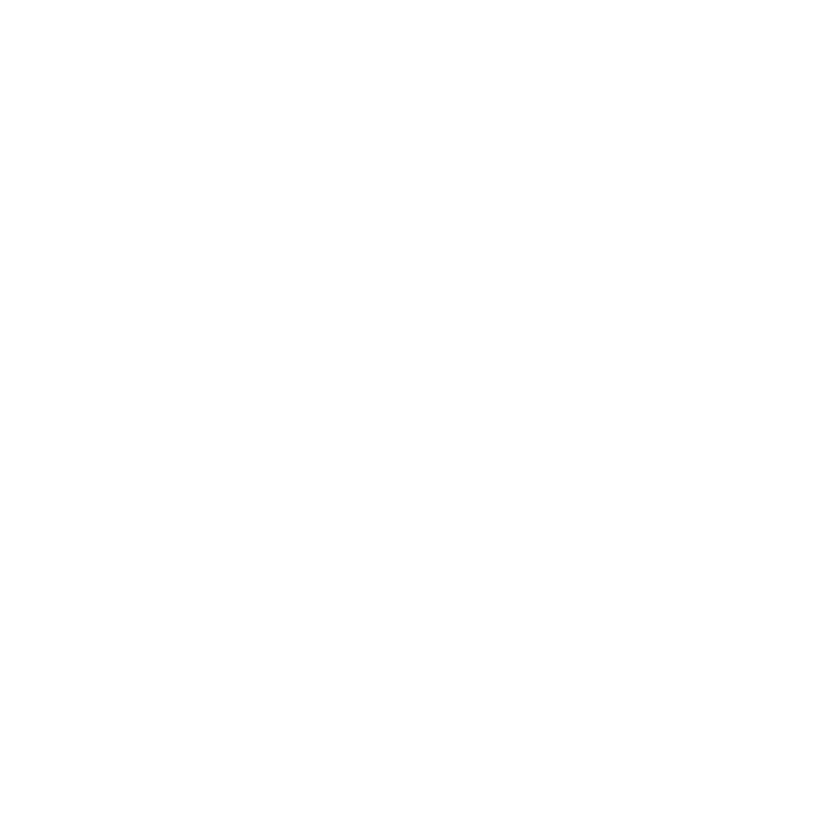

In [11]:
plot(dat$flag_stationarity)